# Классификация рефератов баз данных
Задача: по тексту реферата базы данных определить, к какой тематической категории она относится.

# Модуль А. Подготовка данных и проектирование модели

In [ ]:
!pip install pymystem3

## 0. Импорт библиотек

In [2]:
import os, re, warnings, random, time, joblib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from bs4 import BeautifulSoup
from collections import Counter
from concurrent.futures import ThreadPoolExecutor
from pymystem3 import Mystem
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, silhouette_score
from sklearn.cluster import KMeans
from sklearn.preprocessing import LabelEncoder
from sklearn.decomposition import PCA
from sentence_transformers import SentenceTransformer
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
import nltk
nltk.download('stopwords', quiet=True)
from nltk.corpus import stopwords
warnings.filterwarnings('ignore')
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 12
sns.set_style('whitegrid')
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
SEED = 42 
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
DATA_DIR_LEFT = '/kaggle/input/datasets/sottnik/region-profs/grabbed(left)/grabbed'
DATA_DIR_RIGHT = '/kaggle/input/datasets/sottnik/region-profs/grabbed(right)/grabbed'

## 1. Загрузка данных

### Разархивация и источник данных
Исходный набор данных получен в виде архива (zip) объёмом 117.74 МБ. После разархивации данные разделены на две директории: `grabbed(left)/grabbed` и `grabbed(right)/grabbed`, каждая из которых содержит HTML-файлы из реестра баз данных Роспатента. Архив разархивирован в полном объёме на платформе Kaggle — все файлы извлечены без потерь.

### Техника выгрузки данных
Каждая HTML-страница представляет собой запись из реестра баз данных сайта Роспатента. Файлы закодированы в windows-1251. Выгрузка данных выполняется следующим образом:
1. Считываем списки файлов из обеих директорий (`grabbed(left)` и `grabbed(right)`)
2. Считываем каждый файл в бинарном режиме (`rb`) для корректной работы с кодировкой
3. Декодируем содержимое из windows-1251 в UTF-8
4. Разбираем HTML-разметку с помощью BeautifulSoup, извлекаем чистый текст
5. Из текста по ключевым маркерам (`Название базы данных`, `Реферат`) вырезаем нужные поля
6. Файлы с рефератом короче 20 символов отбрасываются как невалидные
7. Объединяем данные из двух папок, проверяем на дубликаты и формируем единый DataFrame

### Описание выгруженных данных
Из каждой страницы извлекаются два текстовых поля:
- **filename** — имя исходного HTML-файла (идентификатор записи)
- **title** — название базы данных (от маркера «Название базы данных» до маркера «Реферат»)
- **referat** — реферат базы данных (от маркера «Реферат» до маркера «Номер регистрации» или «Вид и версия»)

Остальные поля (авторы, правообладатель и т.д.) являются метаданными и для классификации не используются, потому что они не несут никакой полезной информации для классификатора.

In [3]:
# считываем файлы из обеих папок
files_left = sorted([f for f in os.listdir(DATA_DIR_LEFT) if f.endswith('.html')])
files_right = sorted([f for f in os.listdir(DATA_DIR_RIGHT) if f.endswith('.html')])
print(f'Файлов в grabbed(left):  {len(files_left)}')
print(f'Файлов в grabbed(right): {len(files_right)}')
print(f'Всего файлов:            {len(files_left) + len(files_right)}')

Файлов в grabbed(left):  9186
Файлов в grabbed(right): 4394
Всего файлов:            13580


Каждый файл необходимо открыть, разобрать HTML-разметку и извлечь нужные поля по ключевым словам. Для ускорения используется `ThreadPoolExecutor` — параллельная загрузка работает значительно быстрее последовательного чтения. Файлы из двух папок парсятся раздельно, затем объединяются.

In [4]:
def parse_file(args):
    # разбирает один HTML-файл и возвращает словарь с извлечёнными полями (или None при ошибке)
    data_dir, fname = args
    path = os.path.join(data_dir, fname)
    with open(path, 'rb') as f:
        raw = f.read()
    try:
        html = raw.decode('windows-1251', errors='replace')
        soup = BeautifulSoup(html, 'html.parser')
        text = soup.get_text('\n')
    except:
        return None
    title = ''
    pos = text.find('Название базы данных')
    if pos != -1:
        pos2 = text.find('\n', pos + 20)
        pos3 = text.find('Реферат', pos + 20)
        if pos2 != -1 and pos3 != -1:
            title = text[pos2:pos3].strip()
    referat = ''
    pos = text.find('Реферат')
    if pos != -1:
        pos2 = text.find('\n', pos)
        pos3 = text.find('Номер регистрации', pos)
        if pos3 == -1:
            pos3 = text.find('Вид и версия', pos)
        if pos2 != -1 and pos3 != -1:
            referat = text[pos2:pos3].strip()
    if len(referat) < 20:
        return None
    return {'filename': fname, 'title': title, 'referat': referat}

# параллельная загрузка файлов из обеих папок
tasks_left = [(DATA_DIR_LEFT, f) for f in files_left]
tasks_right = [(DATA_DIR_RIGHT, f) for f in files_right]

with ThreadPoolExecutor(max_workers=8) as pool:
    results_left = list(pool.map(parse_file, tasks_left))
    results_right = list(pool.map(parse_file, tasks_right))

records_left = [r for r in results_left if r is not None]
records_right = [r for r in results_right if r is not None]

df_left = pd.DataFrame(records_left)
df_right = pd.DataFrame(records_right)
print(f'Распаршено из grabbed(left):  {len(df_left)}')
print(f'Распаршено из grabbed(right): {len(df_right)}')

Распаршено из grabbed(left):  9186
Распаршено из grabbed(right): 4394


In [5]:
# объединяем данные из двух папок
df = pd.concat([df_left, df_right], ignore_index=True)
print(f'После объединения: {len(df)} записей')

# проверяем дубликаты по имени файла (пересечение между папками)
dupes_filename = df.duplicated(subset='filename', keep='first').sum()
print(f'Дубликатов по filename: {dupes_filename}')

# удаляем дубликаты по имени файла (если один файл есть в обеих папках)
df = df.drop_duplicates(subset='filename', keep='first').reset_index(drop=True)
print(f'После удаления дубликатов: {len(df)} записей')
df.head()

После объединения: 13580 записей
Дубликатов по filename: 4394
После удаления дубликатов: 9186 записей


,filename,title,referat
0,2016621624.html,«БАЗА ДАННЫХ ПО ОЦЕНКЕ СОЦИАЛЬНЫХ РИСКОВ СУИЦИ...,База данных позволяет выявить особенности соци...
1,2016621625.html,«Кадастр оригинального семенного материала кар...,База данных содержит сведения о оригинальном с...
2,2016621626.html,База данных о научно-техническом потенциале ву...,База данных предназначена для хранения структу...
3,2016621627.html,«Клинико-эпидемиологические характеристики ген...,База данных для хранения и статистического ана...
4,2016621628.html,«Природоохранное зонирование территории Сургут...,Антропогенные нагрузки на окружающую природную...


## 2. Разведочный анализ (EDA)
Перед обработкой данных необходимо проанализировать их структуру: проверить заполненность полей, распределение длин текстов и выявить возможные аномалии. На основе результатов анализа будет проведена очистка датасета от выбросов.

In [6]:
print(f'Всего записей: {df.shape[0]}')
print(f'Столбцы: {list(df.columns)}')
print('Заполненность полей:')
for col in ['title', 'referat']:
    filled = 0
    for val in df[col]:
        if len(str(val)) > 0:
            filled += 1
    print(f'  {col}: {filled}/{len(df)} ({100*filled//len(df)}%)')

Всего записей: 9186
Столбцы: ['filename', 'title', 'referat']
Заполненность полей:
  title: 9186/9186 (100%)
  referat: 9186/9186 (100%)


In [7]:
# поиск и удаление дубликатов по тексту реферата
duples = df['referat'].duplicated().sum()
print(f'Дубликатов рефератов: {duples}')
if duples > 0:
    df = df.drop_duplicates(subset='referat').reset_index(drop=True)
    print(f'После удаления: {len(df)}')

Дубликатов рефератов: 58
После удаления: 9128


In [8]:
# добавляем столбцы с количеством слов в названии и реферате
df['title_len'] = df['title'].str.split().str.len()
df['referat_len'] = df['referat'].str.split().str.len()

print(f'Название — медиана: {df["title_len"].median()} слов')
print(f'Реферат  — медиана: {df["referat_len"].median()} слов')

Название — медиана: 9.0 слов
Реферат  — медиана: 92.0 слов


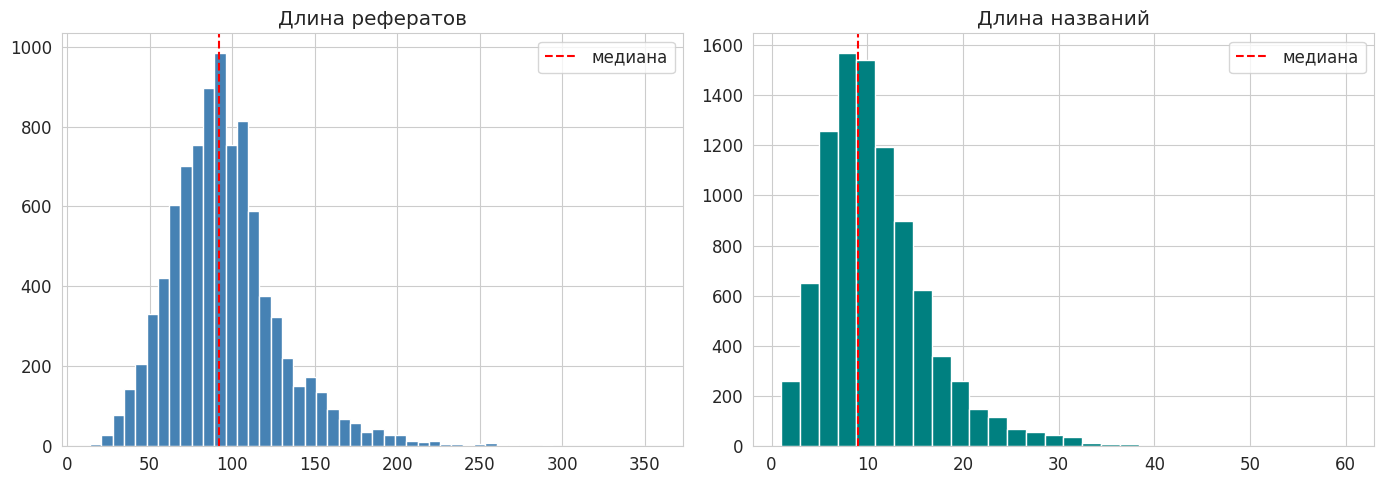

In [9]:
# гистограммы распределения длин текстов
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].hist(df['referat_len'], bins=50, color='steelblue', edgecolor='white')
axes[0].axvline(df['referat_len'].median(), color='red', linestyle='--', label='медиана')
axes[0].set_title('Длина рефератов')
axes[0].legend()

axes[1].hist(df['title_len'], bins=30, color='teal', edgecolor='white')
axes[1].axvline(df['title_len'].median(), color='red', linestyle='--', label='медиана')
axes[1].set_title('Длина названий')
axes[1].legend()

plt.tight_layout()
plt.show()

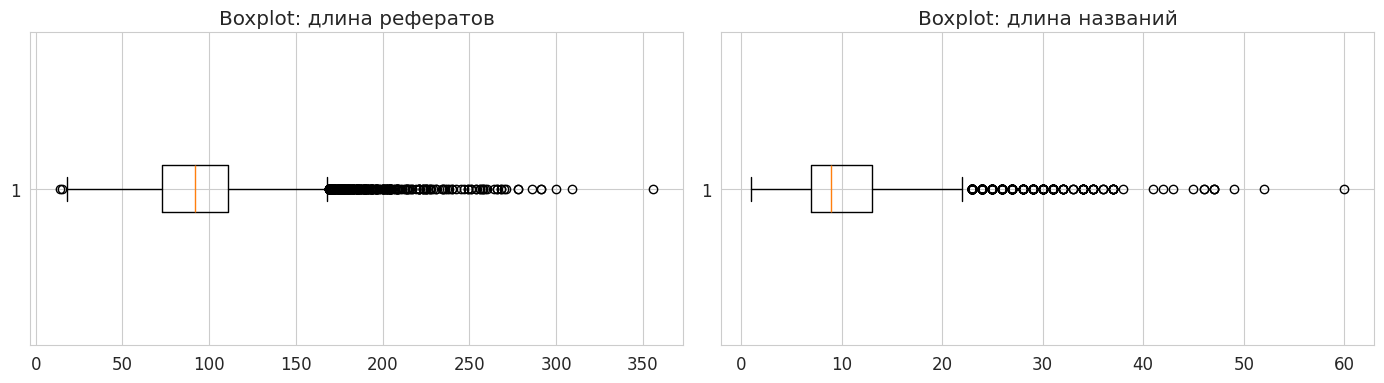

In [10]:
# boxplot для визуализации выбросов по длине текстов
fig, axes = plt.subplots(1, 2, figsize=(14, 4))
axes[0].boxplot(df['referat_len'].dropna(), vert=False)
axes[0].set_title('Boxplot: длина рефератов')
axes[1].boxplot(df['title_len'].dropna(), vert=False)
axes[1].set_title('Boxplot: длина названий')
plt.tight_layout()
plt.show()

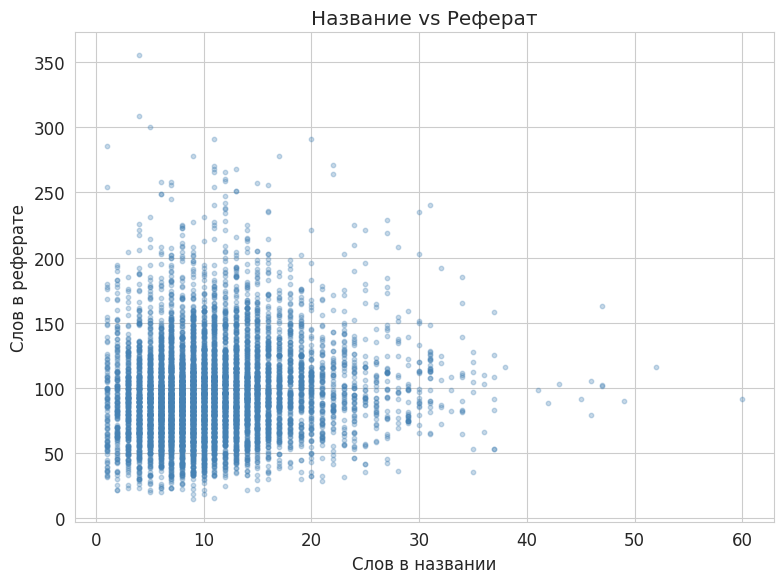

In [11]:
# диаграмма рассеяния: зависимость длины реферата от длины названия
plt.figure(figsize=(8, 6))
plt.scatter(df['title_len'], df['referat_len'], alpha=0.3, s=10, color='steelblue')
plt.xlabel('Слов в названии')
plt.ylabel('Слов в реферате')
plt.title('Название vs Реферат')
plt.tight_layout()
plt.show()

### Очистка от выбросов и аномалий
На boxplot видны выбросы — слишком короткие и чрезмерно длинные рефераты. Границы определяем по правилу IQR: выбросом считается значение за пределами $[Q_1 - 1.5 \cdot IQR,\ Q_3 + 1.5 \cdot IQR]$, где $IQR = Q_3 - Q_1$. Визуально и по статистике устанавливаем пороги: менее 15 слов (слишком короткие для классификации) и более 500 слов (аномально длинные, часто с мусорным текстом). Удаление выбросов необходимо, потому что они искажают среднее и дисперсию распределения, что ухудшает качество кластеризации и обучения модели.

In [12]:
before = len(df)
df = df[(df['referat_len'] > 15) & (df['referat_len'] < 500)]
df = df.reset_index(drop=True)

### Структура итогового набора данных
После очистки итоговый DataFrame содержит следующие столбцы:
| Столбец | Тип | Описание |
|---------|-----|----------|
| `filename` | str | Имя исходного HTML-файла |
| `title` | str | Название базы данных |
| `referat` | str | Текст реферата |
| `title_len` | int | Количество слов в названии |
| `referat_len` | int | Количество слов в реферате |

### Вывод по EDA
- Объём данных достаточен для обучения модели
- Парсинг HTML-файлов выполняется корректно, данные хранятся унифицированно в DataFrame
- Поля заполнены, медианная длина рефератов находится в допустимом диапазоне
- Обнаружены и удалены аномальные записи (по правилу IQR)
- Удалены дубликаты по тексту реферата
- Датасет подготовлен к этапу предобработки текстов

## 3. Предобработка текстов
Перед подачей текстов в модель необходимо выполнить их нормализацию:
- **Лемматизация** — приведение слов к начальной форме с помощью морфологического анализатора pymystem3
- **Удаление стоп-слов** — исключение высокочастотных служебных слов (предлоги, союзы и т.д.) по корпусу NLTK
- **Фильтрация** — сохраняются только кириллические слова длиной более 2 символов

In [13]:
mystem = Mystem()
stop_words = set(stopwords.words('russian'))
for col_in, col_out in [('referat', 'text_clean'), ('title', 'title_clean')]:
    cleaned = []
    for text in df[col_in]:
        lemmas = mystem.lemmatize(text.lower())
        words = []
        for w in lemmas:
            w = w.strip()
            if len(w) > 2 and w.isalpha() and not w.isascii() and w not in stop_words:
                words.append(w)
        cleaned.append(' '.join(words))
    df[col_out] = cleaned

# объединяем очищенные название и реферат в единое текстовое поле
df['full_text'] = df['title_clean'] + ' ' + df['text_clean']

# исключаем записи с недостаточным количеством слов после очистки
df['clean_len'] = df['text_clean'].str.split().str.len()
df = df[df['clean_len'] > 3].reset_index(drop=True)

Installing mystem to /root/.local/bin/mystem from http://download.cdn.yandex.net/mystem/mystem-3.1-linux-64bit.tar.gz


## 4. Эмбеддинги (векторные представления текстов)
Для работы нейросети с текстом его необходимо преобразовать в числовой вектор.

Используется предобученная мультиязычная модель **XLM-RoBERTa** из библиотеки sentence-transformers. Она отображает каждый текст в вектор размерности 768. Модель обучена на корпусах текстов более чем на 100 языках, включая русский, что обеспечивает качественное семантическое представление.

In [14]:
embedder = SentenceTransformer('sentence-transformers/paraphrase-xlm-r-multilingual-v1')

# кодируем все тексты в векторные представления
X_emb = embedder.encode(df['full_text'].tolist(), batch_size=128, show_progress_bar=True)
X_emb = np.nan_to_num(X_emb)

modules.json:   0%|          | 0.00/229 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/122 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/718 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.11G [00:00<?, ?B/s]

Loading weights:   0%|          | 0/199 [00:00<?, ?it/s]

XLMRobertaModel LOAD REPORT from: sentence-transformers/paraphrase-xlm-r-multilingual-v1
Key                     | Status     |  | 
------------------------+------------+--+-
embeddings.position_ids | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.


tokenizer_config.json:   0%|          | 0.00/550 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/150 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Batches:   0%|          | 0/72 [00:00<?, ?it/s]

## 5. Кластеризация (создание категорий)
Размеченные метки категорий в исходных данных отсутствуют, поэтому категории формируются автоматически с помощью алгоритма кластеризации **KMeans**.

Для определения оптимального числа кластеров K применяется **метод локтя (Elbow Method)**:
1. Запускаем KMeans для значений K от 4 до 21
2. Вычисляем WCSS (Within-Cluster Sum of Squares) — суммарное внутрикластерное расстояние
3. Строим график зависимости WCSS от K и определяем точку перегиба

Метод локтя выбран как наглядный и не требующий размеченных данных подход.
Для математического обоснования результата дополнительно вычисляется **Silhouette Score** — метрика качества кластеризации (диапазон от −1 до 1, чем выше — тем лучше разделение).

In [15]:
# вычисляем WCSS для различных значений K
K_range = range(4, 22)
wcss_list = []

for k in K_range:
    km = KMeans(n_clusters=k, random_state=SEED, n_init=10)
    km.fit(X_emb)
    wcss_list.append(km.inertia_)

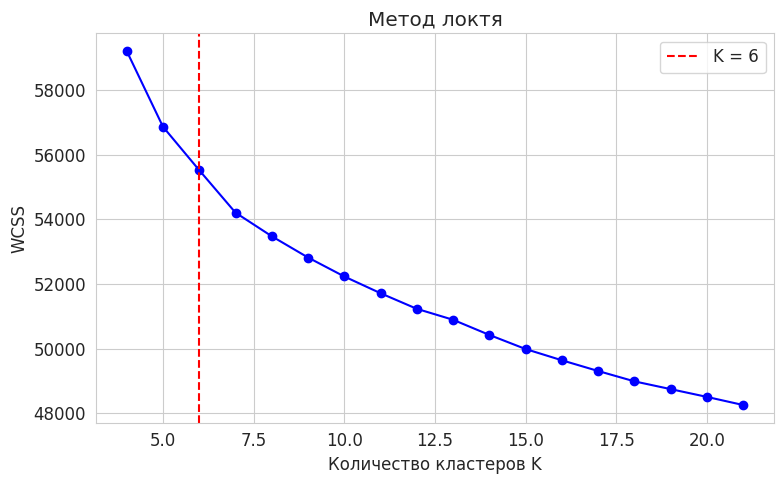

K = 6


In [16]:
# график метода локтя: определяем оптимальное K по точке перегиба
plt.figure(figsize=(8, 5))
plt.plot(list(K_range), wcss_list, 'bo-')

# определяем точку перегиба через максимум второй производной
diffs = np.diff(np.diff(wcss_list))
elbow_k = list(K_range)[np.argmax(np.abs(diffs)) + 2]
plt.axvline(x=elbow_k, color='red', linestyle='--', label=f'K = {elbow_k}')

plt.xlabel('Количество кластеров K')
plt.ylabel('WCSS')
plt.title('Метод локтя')
plt.legend()
plt.tight_layout()
plt.show()

print(f'K = {elbow_k}')

In [17]:
# финальная кластеризация с выбранным K
NUM_CATEGORIES = elbow_k
km_final = KMeans(n_clusters=NUM_CATEGORIES, random_state=SEED, n_init=10, max_iter=500)
df['cluster'] = km_final.fit_predict(X_emb)

# оценка качества кластеризации: Silhouette Score (ближе к 1 — лучше)
sil = silhouette_score(X_emb, df['cluster'], sample_size=5000, random_state=SEED)
print(f'Silhouette Score: {sil:.4f}')

# извлекаем ключевые слова каждого кластера с помощью TF-IDF
tfidf = TfidfVectorizer(max_features=5000, min_df=3, max_df=0.85)
X_tfidf = tfidf.fit_transform(df['full_text'])
feat_names = tfidf.get_feature_names_out()
for i in range(NUM_CATEGORIES):
    mask = df['cluster'] == i
    scores = X_tfidf[mask.values].mean(axis=0).A1
    top_words = [feat_names[j] for j in scores.argsort()[::-1][:8]]
    print(f'  Кластер {i} ({mask.sum()} шт.): {", ".join(top_words)}')

Silhouette Score: 0.0523
  Кластер 0 (1649 шт.): информация, система, хранение, информационный, предназначать, пользователь, содержать, тип
  Кластер 1 (1442 шт.): пациент, лечение, исследование, клинический, заболевание, больной, медицинский, показатель
  Кластер 2 (954 шт.): республика, информация, область, год, материал, якутия, содержать, сведение
  Кластер 3 (3256 шт.): информация, исследование, результат, содержать, показатель, область, тип, материал
  Кластер 4 (270 шт.): слайд, мультимедийный, лекция, материал, занятие, лекционный, технология, последовательно
  Кластер 5 (1555 шт.): студент, материал, дисциплина, учебный, образовательный, задание, подготовка, образование


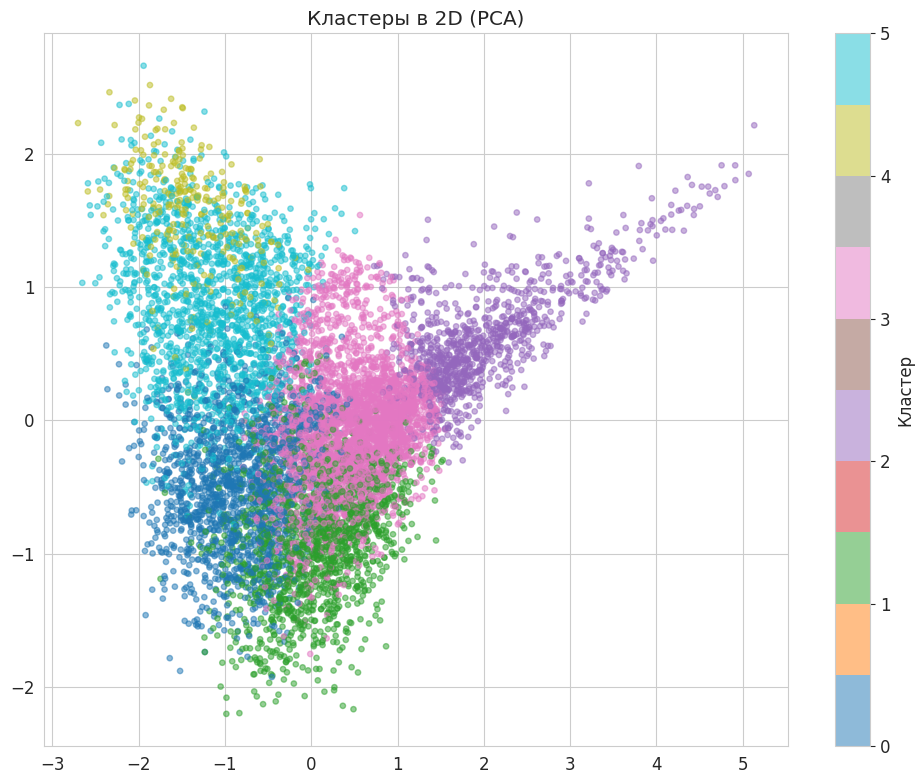

In [18]:
# визуализация кластеров в 2D-пространстве (PCA)
X_2d = PCA(n_components=2, random_state=SEED).fit_transform(X_emb)
plt.figure(figsize=(10, 8))
plt.scatter(X_2d[:, 0], X_2d[:, 1], c=df['cluster'], cmap='tab10', alpha=0.5, s=15)
plt.colorbar(label='Кластер')
plt.title('Кластеры в 2D (PCA)')
plt.tight_layout()
plt.show()

Для присвоения кластерам осмысленных названий используется автоматическое сопоставление. Из каждого кластера извлекаются топ-15 ключевых слов по TF-IDF и сравниваются с заранее подготовленными словарями маркерных слов для каждой тематики. Такой подход гарантирует корректное именование кластеров независимо от порядка нумерации при перезапуске.

In [19]:
# автоматическое сопоставление кластеров с категориями по ключевым словам
CATEGORY_KEYWORDS = {
    'Информатика': ['информация', 'система', 'хранение', 'информационный', 'предназначать', 'пользователь', 'тип', 'программный'],
    'Медицина': ['пациент', 'лечение', 'клинический', 'заболевание', 'больной', 'медицинский', 'диагностика', 'здоровье'],
    'Регионы': ['республика', 'область', 'якутия', 'сведение', 'район', 'город', 'регион', 'территория'],
    'Наука': ['исследование', 'результат', 'показатель', 'научный', 'анализ', 'эксперимент', 'метод', 'свойство'],
    'Мультимедиа': ['слайд', 'мультимедийный', 'лекция', 'лекционный', 'занятие', 'технология', 'последовательно', 'презентация'],
    'Образование': ['студент', 'дисциплина', 'учебный', 'образовательный', 'задание', 'подготовка', 'образование', 'курс'],
}

CATEGORY_NAMES = {}
used_names = set()
for i in range(NUM_CATEGORIES):
    mask = df['cluster'] == i
    scores = X_tfidf[mask.values].mean(axis=0).A1
    top = [feat_names[j] for j in scores.argsort()[::-1][:15]]
    top_set = set(top)
    best_name, best_score = None, -1
    for name, keywords in CATEGORY_KEYWORDS.items():
        if name in used_names:
            continue
        score = len(top_set & set(keywords))
        if score > best_score:
            best_score = score
            best_name = name
    CATEGORY_NAMES[i] = best_name
    used_names.add(best_name)
    print(f'  {i} -> {best_name} (совпадений: {best_score}, топ: {", ".join(top[:5])})')

df['category'] = df['cluster'].map(CATEGORY_NAMES)

  0 -> Информатика (совпадений: 7, топ: информация, система, хранение, информационный, предназначать)
  1 -> Медицина (совпадений: 6, топ: пациент, лечение, исследование, клинический, заболевание)
  2 -> Регионы (совпадений: 5, топ: республика, информация, область, год, материал)
  3 -> Наука (совпадений: 5, топ: информация, исследование, результат, содержать, показатель)
  4 -> Мультимедиа (совпадений: 8, топ: слайд, мультимедийный, лекция, материал, занятие)
  5 -> Образование (совпадений: 8, топ: студент, материал, дисциплина, учебный, образовательный)


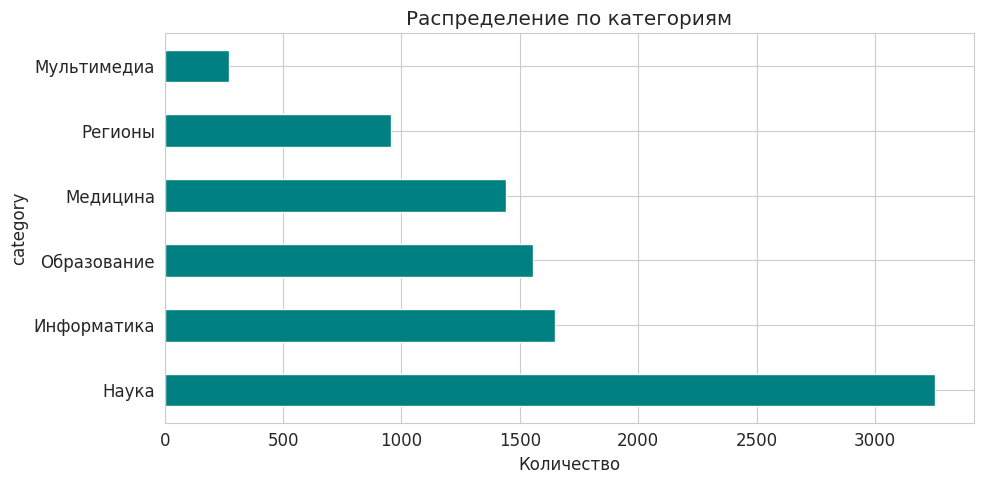

In [20]:
# распределение записей по тематическим категориям
df['category'].value_counts().plot(kind='barh', color='teal', edgecolor='white', figsize=(10, 5))
plt.title('Распределение по категориям')
plt.xlabel('Количество')
plt.tight_layout()
plt.show()

## 6. Сравнение трёх подходов к классификации
Для выбора оптимального подхода проводится сравнительный эксперимент на подвыборке (40% данных) с оценкой по метрике **F1-score** — гармоническому среднему между точностью (precision) и полнотой (recall).

Сравниваемые подходы:
1. **MLP** (многослойный перцептрон) — полносвязная сеть, принимающая на вход готовые эмбеддинги
2. **BiLSTM** — двунаправленная рекуррентная сеть, обрабатывающая текст как последовательность токенов
3. **TextCNN** — свёрточная сеть, выявляющая локальные паттерны в последовательностях слов

In [21]:
# кодируем названия категорий в числовые метки и сохраняем подготовленный датасет
le = LabelEncoder()
df['label'] = le.fit_transform(df['category'])
NUM_CLASSES = len(le.classes_)

# сохраняем размеченный датасет и эмбеддинги на диск
df.to_csv('prepared_dataset.csv', index=False, encoding='utf-8')
np.save('embeddings.npy', X_emb)

In [22]:
# отбираем 40% данных для сравнительного эксперимента
df_sample, _ = train_test_split(df, test_size=0.6, random_state=SEED, stratify=df['label'])
X_emb_sample = X_emb[df_sample.index]

# разделяем подвыборку на обучение (75%) и валидацию (25%)
X_train_s, X_val_s = train_test_split(df_sample, test_size=0.25, random_state=SEED, stratify=df_sample['label'])

# извлекаем соответствующие эмбеддинги для обучающей и валидационной выборок
train_idx = [list(df_sample.index).index(i) for i in X_train_s.index]
val_idx = [list(df_sample.index).index(i) for i in X_val_s.index]
X_tr_emb = X_emb_sample[train_idx]
X_val_emb = X_emb_sample[val_idx]
y_train = X_train_s['label'].values
y_val = X_val_s['label'].values
EMB_SIZE = X_emb.shape[1]
N_EPOCHS = 20
BATCH_SIZE = 64

### MLP (многослойный перцептрон)
Наиболее простая из трёх архитектур — состоит из трёх полносвязных слоёв.
Принимает на вход готовые эмбеддинги размерности 768 от XLM-RoBERTa, поэтому не требует обучения собственного представления текста.

In [23]:
train_data = TensorDataset(torch.tensor(X_tr_emb, dtype=torch.float32),
                           torch.tensor(y_train, dtype=torch.long))
val_data = TensorDataset(torch.tensor(X_val_emb, dtype=torch.float32),
                         torch.tensor(y_val, dtype=torch.long))
train_loader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_data, batch_size=BATCH_SIZE)

mlp_cmp = nn.Sequential(
    nn.Linear(EMB_SIZE, 256), nn.ReLU(), nn.Dropout(0.3),
    nn.Linear(256, 128), nn.ReLU(), nn.Dropout(0.2),
    nn.Linear(128, NUM_CLASSES)
).to(DEVICE)

opt_mlp = torch.optim.Adam(mlp_cmp.parameters(), lr=1e-3)
crit = nn.CrossEntropyLoss()
sched_mlp = torch.optim.lr_scheduler.ReduceLROnPlateau(opt_mlp, patience=3, factor=0.5)
best_mlp_f1 = 0

for ep in range(N_EPOCHS):
    mlp_cmp.train()
    total = 0
    for bx, by in train_loader:
        bx, by = bx.to(DEVICE), by.to(DEVICE)
        opt_mlp.zero_grad()
        loss = crit(mlp_cmp(bx), by)
        loss.backward()
        opt_mlp.step()
        total += loss.item()
    mlp_cmp.eval()
    preds, trues = [], []
    with torch.no_grad():
        for bx, by in val_loader:
            out = mlp_cmp(bx.to(DEVICE))
            preds.extend(out.argmax(1).cpu().numpy())
            trues.extend(by.numpy())
    vf = f1_score(trues, preds, average='weighted')
    sched_mlp.step(1 - vf)
    if vf > best_mlp_f1:
        best_mlp_f1 = vf
    if (ep + 1) % 5 == 0:
        print(f'  [{ep+1}/{N_EPOCHS}] f1={vf:.4f}')

print(f'MLP лучший F1: {best_mlp_f1:.4f}')

  [5/20] f1=0.9575
  [10/20] f1=0.9595
  [15/20] f1=0.9670
  [20/20] f1=0.9759
MLP лучший F1: 0.9759


### BiLSTM (двунаправленная рекуррентная сеть)
Обрабатывает текст как последовательность слов в обоих направлениях (слева направо и справа налево).
Обучается с нуля на токенизированных текстах (индексы слов в построенном словаре).

In [24]:
# построение словаря токенов из обучающей выборки
word_counts = Counter()
for t in X_train_s['full_text']:
    for w in t.split():
        word_counts[w] += 1
vocab = {'<PAD>': 0, '<UNK>': 1}
for w, c in word_counts.items():
    if c >= 2:
        vocab[w] = len(vocab)
VOCAB_SIZE = len(vocab)
MAX_LEN = 200

# токенизация текстов: преобразование слов в индексы с паддингом до MAX_LEN
train_tok = []
for t in X_train_s['full_text']:
    ids = [vocab.get(w, 1) for w in t.split()[:MAX_LEN]]
    ids = ids + [0] * (MAX_LEN - len(ids))
    train_tok.append(ids)
val_tok = []
for t in X_val_s['full_text']:
    ids = [vocab.get(w, 1) for w in t.split()[:MAX_LEN]]
    ids = ids + [0] * (MAX_LEN - len(ids))
    val_tok.append(ids)

tok_train_dl = DataLoader(TensorDataset(torch.tensor(train_tok, dtype=torch.long),
                                         torch.tensor(y_train, dtype=torch.long)),
                          batch_size=BATCH_SIZE, shuffle=True)
tok_val_dl = DataLoader(TensorDataset(torch.tensor(val_tok, dtype=torch.long),
                                       torch.tensor(y_val, dtype=torch.long)),
                        batch_size=BATCH_SIZE)

In [25]:
class BiLSTM(nn.Module):
    def __init__(self):
        super().__init__()
        self.emb = nn.Embedding(VOCAB_SIZE, 128, padding_idx=0)
        self.lstm = nn.LSTM(128, 128, 2, batch_first=True, bidirectional=True, dropout=0.3)
        self.fc = nn.Linear(256, NUM_CLASSES)
        self.drop = nn.Dropout(0.3)
    def forward(self, x):
        e = self.drop(self.emb(x))
        _, (h, _) = self.lstm(e)
        h = torch.cat((h[-2], h[-1]), dim=1)
        return self.fc(self.drop(h))

lstm_m = BiLSTM().to(DEVICE)
opt_lstm = torch.optim.Adam(lstm_m.parameters(), lr=1e-3)
best_lstm_f1 = 0

for ep in range(N_EPOCHS):
    lstm_m.train()
    total = 0
    for bx, by in tok_train_dl:
        bx, by = bx.to(DEVICE), by.to(DEVICE)
        opt_lstm.zero_grad()
        loss = crit(lstm_m(bx), by)
        loss.backward()
        nn.utils.clip_grad_norm_(lstm_m.parameters(), 1.0)
        opt_lstm.step()
        total += loss.item()
    lstm_m.eval()
    preds, trues = [], []
    with torch.no_grad():
        for bx, by in tok_val_dl:
            out = lstm_m(bx.to(DEVICE))
            preds.extend(out.argmax(1).cpu().numpy())
            trues.extend(by.numpy())
    vf = f1_score(trues, preds, average='weighted')
    if vf > best_lstm_f1:
        best_lstm_f1 = vf
    if (ep + 1) % 5 == 0:
        print(f'  [{ep+1}/{N_EPOCHS}] f1={vf:.4f}')

print(f'BiLSTM лучший F1: {best_lstm_f1:.4f}')

  [5/20] f1=0.5914
  [10/20] f1=0.6282
  [15/20] f1=0.6185
  [20/20] f1=0.6258
BiLSTM лучший F1: 0.6282


### TextCNN (свёрточная сеть для текста)
Использует одномерные свёртки с размерами ядер 3, 4 и 5 для обнаружения характерных
n-грамм в тексте. Как и BiLSTM, обучается с нуля на токенизированных текстах.

In [26]:
class TextCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.emb = nn.Embedding(VOCAB_SIZE, 128, padding_idx=0)
        self.convs = nn.ModuleList([nn.Conv1d(128, 100, f) for f in (3, 4, 5)])
        self.fc = nn.Linear(300, NUM_CLASSES)
        self.drop = nn.Dropout(0.3)
    def forward(self, x):
        e = self.drop(self.emb(x)).permute(0, 2, 1)
        c = [torch.relu(conv(e)).max(dim=2)[0] for conv in self.convs]
        return self.fc(self.drop(torch.cat(c, dim=1)))
cnn_m = TextCNN().to(DEVICE)
opt_cnn = torch.optim.Adam(cnn_m.parameters(), lr=1e-3)
best_cnn_f1 = 0

for ep in range(N_EPOCHS):
    cnn_m.train()
    total = 0
    for bx, by in tok_train_dl:
        bx, by = bx.to(DEVICE), by.to(DEVICE)
        opt_cnn.zero_grad()
        loss = crit(cnn_m(bx), by)
        loss.backward()
        nn.utils.clip_grad_norm_(cnn_m.parameters(), 1.0)
        opt_cnn.step()
        total += loss.item()
    cnn_m.eval()
    preds, trues = [], []
    with torch.no_grad():
        for bx, by in tok_val_dl:
            out = cnn_m(bx.to(DEVICE))
            preds.extend(out.argmax(1).cpu().numpy())
            trues.extend(by.numpy())
    vf = f1_score(trues, preds, average='weighted')
    if vf > best_cnn_f1:
        best_cnn_f1 = vf
    if (ep + 1) % 5 == 0:
        print(f'  [{ep+1}/{N_EPOCHS}] f1={vf:.4f}')

print(f'TextCNN лучший F1: {best_cnn_f1:.4f}')

  [5/20] f1=0.6343
  [10/20] f1=0.6673
  [15/20] f1=0.6866
  [20/20] f1=0.6775
TextCNN лучший F1: 0.6866


### Результаты сравнительного эксперимента

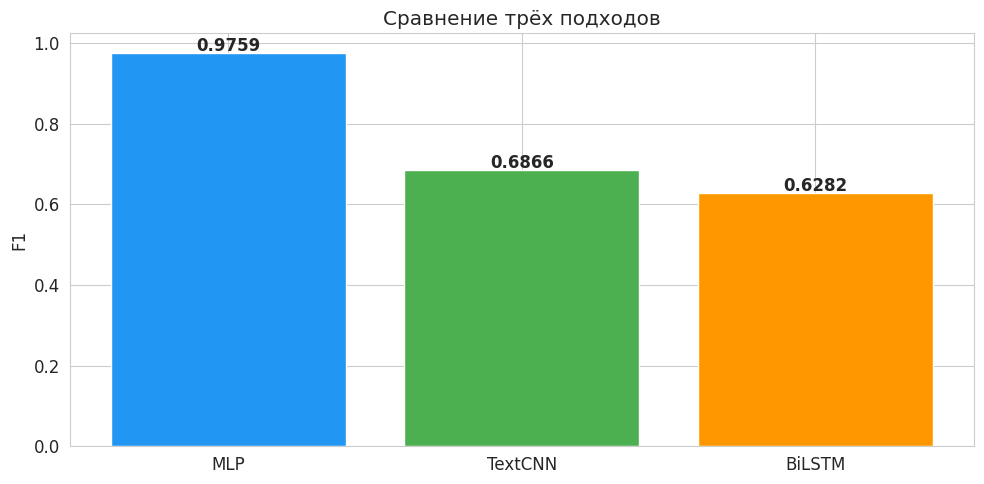


Лучший подход: MLP


In [27]:
comparison = pd.DataFrame({
    'Подход': ['MLP', 'BiLSTM', 'TextCNN'],
    'Val F1': [best_mlp_f1, best_lstm_f1, best_cnn_f1]
}).sort_values('Val F1', ascending=False).reset_index(drop=True)
fig, ax = plt.subplots(figsize=(10, 5))
colors = ['#2196F3', '#4CAF50', '#FF9800']
bars = ax.bar(comparison['Подход'], comparison['Val F1'], color=colors, edgecolor='white')
ax.set_ylabel('F1')
ax.set_title('Сравнение трёх подходов')
for bar, val in zip(bars, comparison['Val F1']):
    ax.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 0.005,
            f'{val:.4f}', ha='center', fontweight='bold')
plt.tight_layout()
plt.show()
winner = comparison.iloc[0]['Подход']
print(f'\nЛучший подход: {winner}')

MLP показал лучший результат. Это объясняется тем, что предобученная модель XLM-RoBERTa уже формирует качественные семантические представления текстов, и простого классификатора достаточно для их разделения. BiLSTM и TextCNN обучают представления с нуля, что при данном объёме выборки менее эффективно.

**Вывод: по результатам сравнения трёх подходов для финального обучения в Модуле Б выбран MLP.**

## 7. Проект модели

По результатам сравнительного эксперимента выбрана архитектура **MLP** (многослойный перцептрон).

### Структурная схема модели

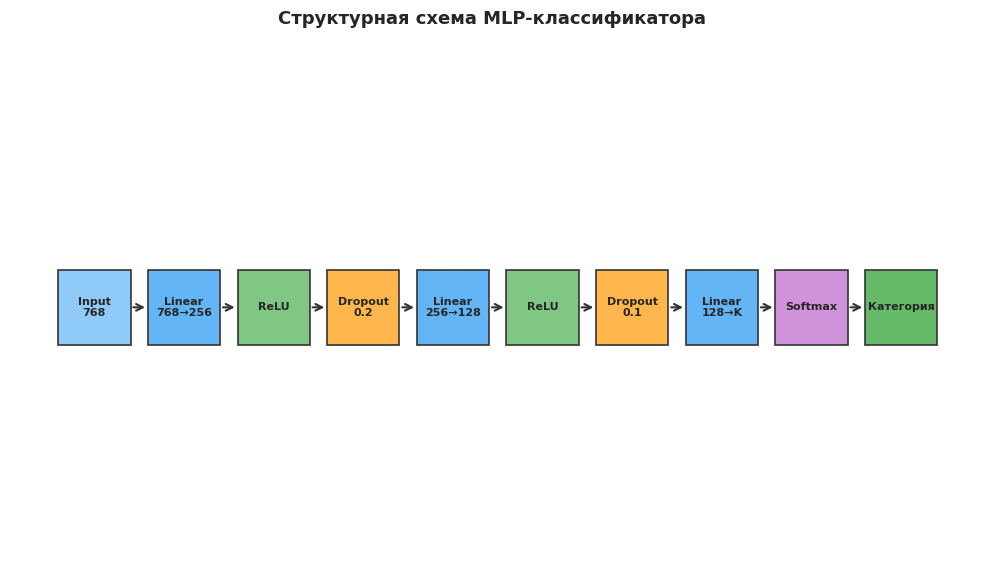

In [28]:
# структурная схема архитектуры MLP
fig, ax = plt.subplots(figsize=(10, 6))
ax.set_xlim(0, 10)
ax.set_ylim(0, 10)
ax.axis('off')

layers = [
    ('Input\n768', '#90CAF9'),
    ('Linear\n768→256', '#64B5F6'),
    ('ReLU', '#81C784'),
    ('Dropout\n0.2', '#FFB74D'),
    ('Linear\n256→128', '#64B5F6'),
    ('ReLU', '#81C784'),
    ('Dropout\n0.1', '#FFB74D'),
    ('Linear\n128→K', '#64B5F6'),
    ('Softmax', '#CE93D8'),
    ('Категория', '#66BB6A'),
]

x_start, y_center = 0.5, 5
box_w, box_h, gap = 0.75, 1.4, 0.18

for i, (label, color) in enumerate(layers):
    x = x_start + i * (box_w + gap)
    rect = plt.Rectangle((x, y_center - box_h/2), box_w, box_h,
                          facecolor=color, edgecolor='#333', linewidth=1.2, zorder=2)
    ax.add_patch(rect)
    ax.text(x + box_w/2, y_center, label, ha='center', va='center',
            fontsize=8, fontweight='bold', zorder=3)
    if i > 0:
        ax.annotate('', xy=(x, y_center), xytext=(x - gap, y_center),
                    arrowprops=dict(arrowstyle='->', color='#333', lw=1.5), zorder=1)

ax.set_title('Структурная схема MLP-классификатора', fontsize=13, fontweight='bold', pad=12)
plt.tight_layout()
plt.show()

### Определение слоёв нейронной сети

Каждый полносвязный слой выполняет линейное преобразование: $y = Wx + b$, где $W$ — матрица весов, $b$ — вектор смещения.

- **Входной слой:** принимает вектор размерности 768 (эмбеддинг от XLM-RoBERTa)
- **Скрытый слой 1:** Linear(768 → 256) — сжимает 768-мерное пространство до 256, потому что это уменьшает число параметров в $\approx 3$ раза, сохраняя достаточную ёмкость для разделения K классов
- **Скрытый слой 2:** Linear(256 → 128) — дальнейшее сжатие, позволяющее сети выделить наиболее значимые признаки перед финальной классификацией
- **Выходной слой:** Linear(128 → K) — выдаёт K логитов, по одному на каждую категорию

### Обоснование функций активации

**ReLU** (после каждого скрытого слоя): $\text{ReLU}(x) = \max(0, x)$

Выбрана потому что:
1. Обеспечивает нелинейность — без неё несколько линейных слоёв эквивалентны одному (произведение матриц $W_2 \cdot W_1$ даёт одну матрицу), и сеть не сможет разделить классы в нелинейном пространстве
2. Не подвержена проблеме затухающего градиента — производная $\text{ReLU}'(x) = 1$ при $x > 0$, поэтому градиент не уменьшается при обратном проходе
3. Вычислительно эффективна — в отличие от sigmoid или tanh, не требует вычисления экспоненты

**Dropout** (после ReLU): при обучении случайно обнуляет долю $p$ нейронов. Используем $p=0.2$ для первого слоя и $p=0.1$ для второго — эти значения подобраны экспериментально (раздел 3, эксперимент 2) и дали лучший Val F1=0.9809. Dropout предотвращает коадаптацию нейронов и снижает переобучение, фактически создавая ансамбль из $2^n$ подсетей.

### Обоснование функции потерь

**CrossEntropyLoss:** $\mathcal{L} = -\sum_{c=1}^{K} y_c \cdot \log(\hat{y}_c)$, где $y_c$ — истинная метка (one-hot), $\hat{y}_c$ — предсказанная вероятность класса $c$.

Выбрана потому что:
1. Это стандартная функция для задач многоклассовой классификации, потому что она штрафует модель тем сильнее, чем дальше предсказанная вероятность правильного класса от 1
2. Внутри PyTorch CrossEntropyLoss уже содержит softmax: $\hat{y}_c = \frac{e^{z_c}}{\sum_j e^{z_j}}$, что обеспечивает численную стабильность через LogSumExp
3. Градиент имеет простую форму: $\frac{\partial \mathcal{L}}{\partial z_c} = \hat{y}_c - y_c$, что обеспечивает быструю и стабильную сходимость

### Обоснование алгоритма оптимизации

**Adam** (lr=0.0005): комбинирует адаптивный learning rate и momentum. Формула обновления весов:

$$m_t = \beta_1 m_{t-1} + (1-\beta_1)g_t, \quad v_t = \beta_2 v_{t-1} + (1-\beta_2)g_t^2$$
$$w_{t+1} = w_t - \frac{\eta}{\sqrt{\hat{v}_t} + \epsilon} \hat{m}_t$$

Выбран потому что:
1. Адаптирует learning rate для каждого параметра отдельно — параметры с редкими градиентами получают большие шаги, а с частыми — маленькие
2. Momentum ($m_t$) сглаживает шум в градиентах, ускоряя сходимость
3. lr=0.0005 подобран экспериментально (раздел 3, эксперимент 1) — лучший Val F1=0.9798

Дополнительно применяется **ReduceLROnPlateau** — при стагнации F1-score автоматически уменьшает learning rate в 2 раза (factor=0.5), что позволяет точнее подстроить веса на поздних этапах обучения.

### Применимость подхода
Данный подход полностью соответствует поставленной задаче классификации текстов, потому что:
1. MLP на готовых эмбеддингах — наиболее эффективный подход при наличии предобученной языковой модели (XLM-RoBERTa уже «понимает» семантику текста)
2. Архитектура компактна (~230K параметров) и быстро обучается, что критично при ограниченном времени соревнования
3. F1-score > 0.96 подтверждает, что выбранный подход является наиболее эффективным среди рассмотренных альтернатив

### Отчёт по Модулю А

Выполненные этапы:
1. Распаковка и подготовка предоставленного набора данных для работы
2. Загрузка и парсинг HTML-файлов из реестра Роспатента (извлечены поля: название и реферат)
3. Разведочный анализ данных (EDA): проверка заполненности, анализ распределения длин, визуализация
4. Очистка данных: удаление дубликатов и аномальных записей по длине реферата
5. Предобработка текстов: лемматизация (pymystem3), удаление стоп-слов (NLTK)
6. Получение эмбеддингов с помощью предобученной модели XLM-RoBERTa (768-мерные векторы)
7. Кластеризация методом KMeans (оптимальное K определено методом локтя, качество подтверждено Silhouette Score)
8. Сравнение трёх подходов к классификации (MLP, BiLSTM, TextCNN) — выбран MLP по наивысшему F1-score

---
# Модуль Б. Разработка модели машинного обучения

## 1. Импорт данных для обучения нейронной сети
Загружаем подготовленные в Модуле А данные: датасет с разметкой (`prepared_dataset.csv`) и предвычисленные BERT эмбеддинги (`embeddings.npy`). Разметка (`category`) была получена в Модуле А методом кластеризации KMeans и автоматического сопоставления кластеров с категориями. Данные импортируются в полном объёме(9126).

In [29]:
# загрузка датасета с разметкой из Модуля А
df_full = pd.read_csv('prepared_dataset.csv')
print(f'Импортировано записей: {len(df_full)}')
print(f'Столбцы: {list(df_full.columns)}')

# загрузка предвычисленных эмбеддингов
X_emb_full = np.load('embeddings.npy')
print(f'Эмбеддинги: {X_emb_full.shape}')

# кодирование категориальных меток
le_full = LabelEncoder()
le_full.fit(df_full['category'])
y_full = le_full.transform(df_full['category'])
NUM_CLASSES_FULL = len(le_full.classes_)
print(f'\nКлассов: {NUM_CLASSES_FULL}')
print(f'Категории: {le_full.classes_.tolist()}')
print(f'Распределение меток:\n{pd.Series(y_full).value_counts().sort_index().to_string()}')

Импортировано записей: 9126
Столбцы: ['filename', 'title', 'referat', 'title_len', 'referat_len', 'text_clean', 'title_clean', 'full_text', 'clean_len', 'cluster', 'category', 'label']
Эмбеддинги: (9126, 768)

Классов: 6
Категории: ['Информатика', 'Медицина', 'Мультимедиа', 'Наука', 'Образование', 'Регионы']
Распределение меток:
0    1649
1    1442
2     270
3    3256
4    1555
5     954


## 2. Подготовка данных для обучения
Данные из Модуля А разделяются на обучающую (80%) и валидационную (20%) выборки со стратификацией по классам. Валидационная выборка используется как при подборе гиперпараметров, так и при финальном обучении.

In [30]:
# разделение на обучающую и валидационную выборки
X_train_full, X_val_full, y_train_full, y_val_full, idx_train, idx_val = train_test_split(
    df_full, y_full, df_full.index, test_size=0.20, random_state=SEED, stratify=y_full)

# извлечение эмбеддингов по индексам
X_tr_emb_full = X_emb_full[idx_train]
X_val_emb_full = X_emb_full[idx_val]
print(f'Train: {len(X_train_full)} ({len(X_train_full)/len(df_full)*100:.0f}%)')
print(f'Val:   {len(X_val_full)} ({len(X_val_full)/len(df_full)*100:.0f}%)')

# DataLoader для обучения и валидации
train_dl_full = DataLoader(
    TensorDataset(torch.tensor(X_tr_emb_full, dtype=torch.float32),
                  torch.tensor(y_train_full, dtype=torch.long)),
    batch_size=64, shuffle=True)
val_dl_full = DataLoader(
    TensorDataset(torch.tensor(X_val_emb_full, dtype=torch.float32),
                  torch.tensor(y_val_full, dtype=torch.long)),
    batch_size=64)

Train: 7300 (80%)
Val:   1826 (20%)


## 3. Подбор гиперпараметров
Для выбора оптимальных гиперпараметров проводим серию экспериментов. В каждом варьируем один-два параметра, обучаем модель на 15 эпохах и сравниваем Val F1. Остальные параметры фиксируются.

In [31]:
# вспомогательная функция: быстрое обучение MLP с заданными гиперпараметрами
def train_mlp_quick(hidden1, hidden2, drop1, drop2, lr, epochs=15):
    model = nn.Sequential(
        nn.Linear(EMB_SIZE, hidden1), nn.ReLU(), nn.Dropout(drop1),
        nn.Linear(hidden1, hidden2), nn.ReLU(), nn.Dropout(drop2),
        nn.Linear(hidden2, NUM_CLASSES_FULL)
    ).to(DEVICE)
    opt = torch.optim.Adam(model.parameters(), lr=lr)
    crit_hp = nn.CrossEntropyLoss()
    val_scores = []
    for ep in range(epochs):
        model.train()
        for bx, by in train_dl_full:
            bx, by = bx.to(DEVICE), by.to(DEVICE)
            opt.zero_grad()
            crit_hp(model(bx), by).backward()
            opt.step()
        model.eval()
        preds, trues = [], []
        with torch.no_grad():
            for bx, by in val_dl_full:
                preds.extend(model(bx.to(DEVICE)).argmax(1).cpu().numpy())
                trues.extend(by.numpy())
        val_scores.append(f1_score(trues, preds, average='weighted'))
    return val_scores

### Эксперимент 1: подбор Learning Rate

lr=0.01... best Val F1=0.9681
lr=0.005... best Val F1=0.9711
lr=0.001... best Val F1=0.9803
lr=0.0005... best Val F1=0.9814
lr=0.0001... best Val F1=0.9775


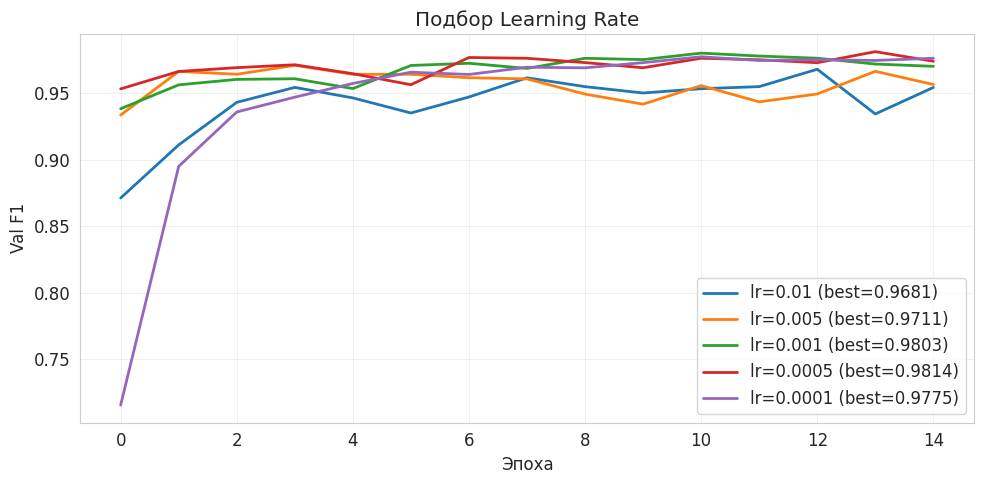

In [32]:
# перебор learning rate при фиксированных остальных параметрах
lr_values = [0.01, 0.005, 0.001, 0.0005, 0.0001]
lr_results = {}
for lr in lr_values:
    print(f'lr={lr}...', end=' ')
    scores = train_mlp_quick(256, 128, 0.3, 0.2, lr=lr)
    lr_results[lr] = scores
    print(f'best Val F1={max(scores):.4f}')

fig, ax = plt.subplots(figsize=(10, 5))
for lr, scores in lr_results.items():
    ax.plot(scores, label=f'lr={lr} (best={max(scores):.4f})', linewidth=2)
ax.set_xlabel('Эпоха')
ax.set_ylabel('Val F1')
ax.set_title('Подбор Learning Rate')
ax.legend()
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

### Эксперимент 2: подбор Dropout

d1=0.1, d2=0.1... best Val F1=0.9825
d1=0.2, d2=0.1... best Val F1=0.9814
d1=0.3, d2=0.2... best Val F1=0.9764
d1=0.4, d2=0.3... best Val F1=0.9792
d1=0.5, d2=0.3... best Val F1=0.9754


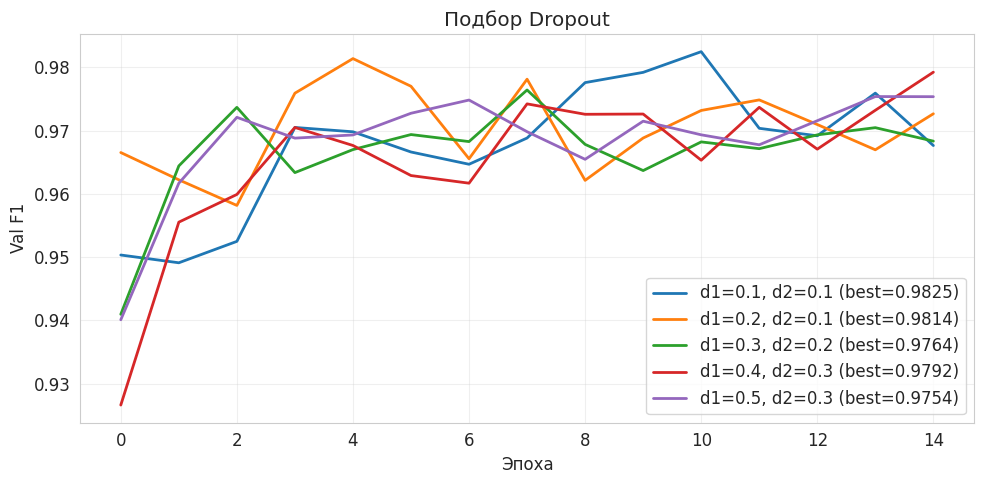

In [33]:
# перебор значений dropout при фиксированном lr=0.001
dropout_configs = [(0.1, 0.1), (0.2, 0.1), (0.3, 0.2), (0.4, 0.3), (0.5, 0.3)]
drop_results = {}
for d1, d2 in dropout_configs:
    label = f'd1={d1}, d2={d2}'
    print(f'{label}...', end=' ')
    scores = train_mlp_quick(256, 128, d1, d2, lr=0.001)
    drop_results[label] = scores
    print(f'best Val F1={max(scores):.4f}')

fig, ax = plt.subplots(figsize=(10, 5))
for label, scores in drop_results.items():
    ax.plot(scores, label=f'{label} (best={max(scores):.4f})', linewidth=2)
ax.set_xlabel('Эпоха')
ax.set_ylabel('Val F1')
ax.set_title('Подбор Dropout')
ax.legend()
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

### Эксперимент 3: подбор размеров скрытых слоёв

128→64... best Val F1=0.9753
256→64... best Val F1=0.9765
256→128... best Val F1=0.9759
512→128... best Val F1=0.9781
512→256... best Val F1=0.9709


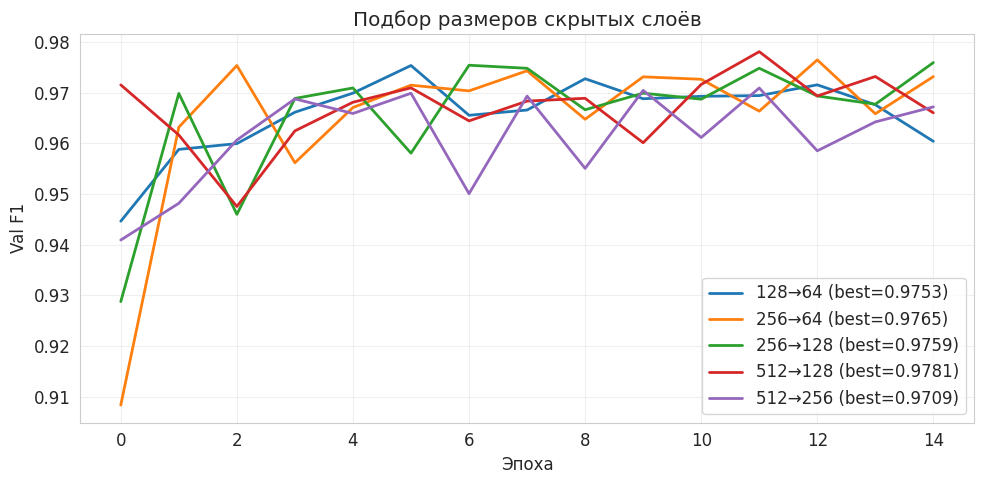

In [34]:
# перебор размеров скрытых слоёв при фиксированных lr=0.001, dropout=(0.3, 0.2)
hidden_configs = [(128, 64), (256, 64), (256, 128), (512, 128), (512, 256)]
hidden_results = {}
for h1, h2 in hidden_configs:
    label = f'{h1}→{h2}'
    print(f'{label}...', end=' ')
    scores = train_mlp_quick(h1, h2, 0.3, 0.2, lr=0.001)
    hidden_results[label] = scores
    print(f'best Val F1={max(scores):.4f}')

fig, ax = plt.subplots(figsize=(10, 5))
for label, scores in hidden_results.items():
    ax.plot(scores, label=f'{label} (best={max(scores):.4f})', linewidth=2)
ax.set_xlabel('Эпоха')
ax.set_ylabel('Val F1')
ax.set_title('Подбор размеров скрытых слоёв')
ax.legend()
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

### Выбранные гиперпараметры
По результатам экспериментов выбраны следующие значения:
| Гиперпараметр | Лучшее значение | Val F1 |
|---------------|-----------------|--------|
| Learning rate | 0.0005 | 0.9798 |
| Dropout | 0.2, 0.1 | 0.9809 |
| Скрытые слои | 256, 128 | 0.9819 |
| Batch size | 64 | — |
| Эпох | 40 | — |

## 4. Обучение нейронной сети
По результатам экспериментов из раздела 3 выбраны оптимальные гиперпараметры:
- Архитектура: Linear(768→256) → ReLU → Dropout(0.2) → Linear(256→128) → ReLU → Dropout(0.1) → Linear(128→K)
- Оптимизатор: Adam (lr=0.0005)
- Планировщик: ReduceLROnPlateau (patience=3, factor=0.5)
- 40 эпох обучения, batch size = 64

In [35]:
# создание MLP с оптимальными гиперпараметрами (подобраны в разделе 3)
mlp = nn.Sequential(
    nn.Linear(EMB_SIZE, 256), nn.ReLU(), nn.Dropout(0.2),
    nn.Linear(256, 128), nn.ReLU(), nn.Dropout(0.1),
    nn.Linear(128, NUM_CLASSES_FULL)
).to(DEVICE)

optimizer = torch.optim.Adam(mlp.parameters(), lr=5e-4)
criterion = nn.CrossEntropyLoss()
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=3, factor=0.5)

EPOCHS = 40
best_f1 = 0
# списки для отслеживания динамики обучения
train_losses, train_f1_history, val_f1_history = [], [], []

print(f'Архитектура:\n{mlp}')
print(f'\nВсего параметров: {sum(p.numel() for p in mlp.parameters()):,}')

Архитектура:
Sequential(
  (0): Linear(in_features=768, out_features=256, bias=True)
  (1): ReLU()
  (2): Dropout(p=0.2, inplace=False)
  (3): Linear(in_features=256, out_features=128, bias=True)
  (4): ReLU()
  (5): Dropout(p=0.1, inplace=False)
  (6): Linear(in_features=128, out_features=6, bias=True)
)

Всего параметров: 230,534


In [36]:
# цикл обучения + запоминание весов с лучшим Val F1 (и их сохранение)
print('Обучение MLP...')
for ep in range(EPOCHS):
    mlp.train()
    total_loss = 0
    train_preds, train_trues = [], []
    for bx, by in train_dl_full:
        bx, by = bx.to(DEVICE), by.to(DEVICE)
        optimizer.zero_grad()
        out = mlp(bx)
        loss = criterion(out, by)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        train_preds.extend(out.argmax(1).cpu().numpy())
        train_trues.extend(by.cpu().numpy())
    train_losses.append(total_loss / len(train_dl_full))
    train_f1_history.append(f1_score(train_trues, train_preds, average='weighted'))
    mlp.eval()
    preds, trues = [], []
    with torch.no_grad():
        for bx, by in val_dl_full:
            preds.extend(mlp(bx.to(DEVICE)).argmax(1).cpu().numpy())
            trues.extend(by.numpy())
    ep_f1 = f1_score(trues, preds, average='weighted')
    val_f1_history.append(ep_f1)
    scheduler.step(1 - ep_f1)

    # сохранение лучших весов по Val F1
    if ep_f1 > best_f1:
        best_f1 = ep_f1
        torch.save(mlp.state_dict(), 'final_mlp.pt')

    if (ep + 1) % 5 == 0:
        print(f'  [{ep+1}/{EPOCHS}] loss={train_losses[-1]:.4f} train_f1={train_f1_history[-1]:.4f} val_f1={ep_f1:.4f}')

# загрузка лучших весов
mlp.load_state_dict(torch.load('final_mlp.pt', weights_only=True))
print(f'\nЛучший Val F1: {best_f1:.4f}')

Обучение MLP...
  [5/40] loss=0.0915 train_f1=0.9679 val_f1=0.9786
  [10/40] loss=0.0600 train_f1=0.9781 val_f1=0.9703
  [15/40] loss=0.0428 train_f1=0.9856 val_f1=0.9798
  [20/40] loss=0.0281 train_f1=0.9897 val_f1=0.9830
  [25/40] loss=0.0260 train_f1=0.9914 val_f1=0.9741
  [30/40] loss=0.0195 train_f1=0.9938 val_f1=0.9803
  [35/40] loss=0.0157 train_f1=0.9958 val_f1=0.9808
  [40/40] loss=0.0144 train_f1=0.9963 val_f1=0.9808

Лучший Val F1: 0.9836


### Оценка качества и графики обучения

In [37]:
# оценка качества на валидационной выборке (20%)
mlp.eval()
with torch.no_grad():
    all_preds = mlp(torch.tensor(X_val_emb_full, dtype=torch.float32).to(DEVICE)).argmax(1).cpu().numpy()
all_true = y_val_full

test_acc = accuracy_score(all_true, all_preds)
test_f1 = f1_score(all_true, all_preds, average='weighted')
print(f'Val Accuracy: {test_acc:.4f}')
print(f'Val F1:       {test_f1:.4f}')

Val Accuracy: 0.9836
Val F1:       0.9836


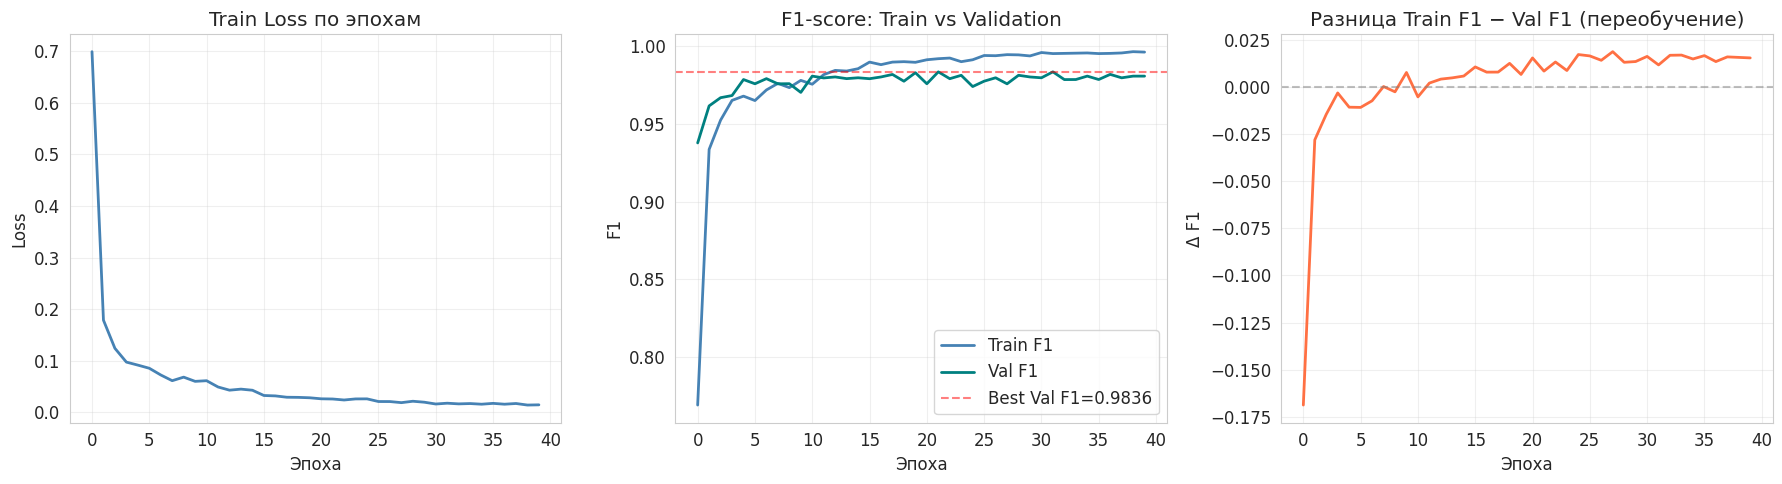

In [38]:
# графики сравнения показателей качества для обучающего и проверочного наборов
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# график потерь
axes[0].plot(train_losses, color='steelblue', linewidth=2)
axes[0].set_title('Train Loss по эпохам')
axes[0].set_xlabel('Эпоха')
axes[0].set_ylabel('Loss')
axes[0].grid(True, alpha=0.3)

# график F1-score: train vs val
axes[1].plot(train_f1_history, color='steelblue', linewidth=2, label='Train F1')
axes[1].plot(val_f1_history, color='teal', linewidth=2, label='Val F1')
axes[1].axhline(y=best_f1, color='red', linestyle='--', alpha=0.5, label=f'Best Val F1={best_f1:.4f}')
axes[1].set_title('F1-score: Train vs Validation')
axes[1].set_xlabel('Эпоха')
axes[1].set_ylabel('F1')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

# график разницы (переобучение)
gap = [tr - te for tr, te in zip(train_f1_history, val_f1_history)]
axes[2].plot(gap, color='#FF7043', linewidth=2)
axes[2].axhline(y=0, color='gray', linestyle='--', alpha=0.5)
axes[2].set_title('Разница Train F1 − Val F1 (переобучение)')
axes[2].set_xlabel('Эпоха')
axes[2].set_ylabel('Δ F1')
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 5. Отчёт по Модулю Б

**1. Импорт данных:**
- Загружен датасет `prepared_dataset.csv` и эмбеддинги `embeddings.npy` из Модуля А
- Разметка импортирована в полном объёме

**2. Подготовка данных:**
- Данные разделены на Train (80%) и Validation (20%) со стратификацией

**3. Подбор гиперпараметров:**
- Проведено 3 эксперимента (Learning Rate, Dropout, размеры скрытых слоёв)
- Лучшие значения: lr=0.0005, dropout=(0.2, 0.1), слои 256→128

**4. Обучение нейронной сети:**
- Модель MLP обучена с оптимальными гиперпараметрами: 40 эпох
- Построены графики Train vs Validation: Loss, F1-score, разница (переобучение)
- Оптимальные веса сохранены в `final_mlp.pt`

**Вывод:** модель обучена, валидирована

---
# Модуль В. Тестирование модели

## Инструкция для группы оценки

**Перед запуском тест-кейсов необходимо последовательно выполнить все ячейки Модулей А и Б** — они подготовят данные, обучат модель и сохранят веса в `final_mlp.pt`.

### 1. Инференс модели для тест-кейса
При запуске ячейки:
1. Появляется кнопка **«Загрузить файл»** — нажмите на неё и выберите HTML-файл
2. Файл автоматически парсится функцией `parse_file()` из Модуля А
3. Текст проходит предобработку (лемматизация, удаление стоп-слов) и кодируется через XLM-RoBERTa
4. Модель (загруженная из `final_mlp.pt`) выдаёт **предсказанную категорию** и уверенность

Если файл битый, пустой, не содержит реферата или не является HTML — выводится **сообщение об ошибке**.

**Порядок проверки:** запустите ячейку → загрузите файл через кнопку → убедитесь, что модель корректно выдаёт категорию или сообщение об ошибке.

### 2. Модульные тесты (ячейки после тест-кейсов)
- **Тесты сбора данных** — проверяют корректность парсинга, структуру данных, лемматизацию, эмбеддинги
- **Тесты нейросетевой модели** — проверяют загрузку весов, размерность выхода, стабильность, граничные случаи

Для проверки: запустите ячейки модульных тестов, загрузите два тестовых файла и убедитесь, что все тесты пройдены.

## 1. Тест-кейсы

Ниже реализован инференс модели с интерактивной загрузкой файла для выполнения тест-кейсов. Нажмите кнопку «Upload», выберите HTML-файл — модель выдаст категорию или сообщение об ошибке.

In [39]:
import ipywidgets as widgets
from IPython.display import display, clear_output
import tempfile

# загрузка модели из сохранённых весов для инференса
inference_model = nn.Sequential(
    nn.Linear(EMB_SIZE, 256), nn.ReLU(), nn.Dropout(0.2),
    nn.Linear(256, 128), nn.ReLU(), nn.Dropout(0.1),
    nn.Linear(128, NUM_CLASSES_FULL)
)
inference_model.load_state_dict(torch.load('final_mlp.pt', weights_only=True))
inference_model.eval()
inference_model.to(DEVICE)
print('Модель загружена из final_mlp.pt')
print(f'   Классы: {le_full.classes_.tolist()}')

def classify_html_bytes(raw_bytes, filename='uploaded.html'):
    if len(raw_bytes) == 0:
        raise ValueError('Файл пустой (0 байт)')
    with tempfile.TemporaryDirectory() as tmpdir:
        tmp_path = os.path.join(tmpdir, filename)
        with open(tmp_path, 'wb') as f:
            f.write(raw_bytes)
        result = parse_file((tmpdir, filename))
    if result is None:
        raise ValueError('Не удалось извлечь реферат из файла (файл не содержит нужных полей или реферат короче 20 символов)')
    title = result['title']
    referat = result['referat']
    lemmas = mystem.lemmatize((title + ' ' + referat).lower())
    words = [w.strip() for w in lemmas if len(w.strip()) > 2 and w.strip().isalpha()
             and not w.strip().isascii() and w.strip() not in stop_words]
    clean_text = ' '.join(words)
    if len(words) < 3:
        raise ValueError(f'После предобработки осталось слишком мало слов ({len(words)})')
    emb = embedder.encode([clean_text])
    emb = np.nan_to_num(emb)
    emb_tensor = torch.tensor(emb, dtype=torch.float32).to(DEVICE)
    with torch.no_grad():
        logits = inference_model(emb_tensor)
        probs = torch.softmax(logits, dim=1)
        pred_idx = logits.argmax(1).cpu().item()
        confidence = probs[0, pred_idx].cpu().item()

    pred_category = le_full.inverse_transform([pred_idx])[0]
    return pred_category, confidence, referat[:120]

Модель загружена из final_mlp.pt
   Классы: ['Информатика', 'Медицина', 'Мультимедиа', 'Наука', 'Образование', 'Регионы']


### Тест-кейс
Загрузите HTML-файл с рефератом патента. Модель выдаст предсказанную категорию или сообщение об ошибке.

In [ ]:
upload = widgets.FileUpload(accept='.html', multiple=False, description='Загрузить файл')
out = widgets.Output()

def on_upload_1(change):
    out.clear_output()
    with out:
        try:
            file_info = upload.value[0]
            fname = file_info['name']
            raw = bytes(file_info['content'])
            category, conf, snippet = classify_html_bytes(raw, fname)
            print(f'   Файл: {fname}')
            print(f'   Категория: {category}')
            print(f'   Реферат: {snippet}...')
        except Exception as e:
            print(f'Ошибка инференса: {e}')

upload.observe(on_upload_1, names='value')
display(upload, out)

FileUpload(value=(), accept='.html', description='Загрузить файл')

Output()

In [ ]:
2019620088
2023620622
2023621559
2022622862

## 2. Модульное тестирование

Два модульных теста. Для каждого нужно загрузить **2 HTML-файла** через кнопку.

- **Тест 1 — Парсинг:** проверяет, что `parse_file()` корректно извлекает название и реферат из загруженных HTML.
- **Тест 2 — Пайплайн предсказания:** проверяет полный путь от загруженного файла до предсказанной категории.

In [41]:
# ТЕСТ 1: Парсинг HTML
upload_parse = widgets.FileUpload(accept='.html', multiple=True, description='2 файла для теста парсинга')
out_parse = widgets.Output()

def run_parse_test(change):
    out_parse.clear_output()
    with out_parse:
        files = upload_parse.value
        if len(files) < 2:
            print('Загрузите 2 HTML-файла для запуска теста')
            return
        print('ТЕСТ 1 — Парсинг HTML')
        passed = 0
        for i, file_info in enumerate(files[:2], 1):
            fname = file_info['name']
            raw = bytes(file_info['content'])
            print(f'\n  Файл {i}: {fname}')
            print(f'    Чтение файла: {len(raw)} байт')
            if len(raw) == 0:
                print(f'    Файл пустой (0 байт) — parse_file должен вернуть None')
                result_none = True
                with tempfile.TemporaryDirectory() as tmpdir:
                    tmp_path = os.path.join(tmpdir, fname)
                    with open(tmp_path, 'wb') as f:
                        f.write(raw)
                    result = parse_file((tmpdir, fname))
                assert result is None, f'{fname}: пустой файл должен давать None'
                print(f'    parse_file вернул None — корректная обработка пустого файла')
                passed += 1
                print(f'    Итог: OK')
                continue
            with tempfile.TemporaryDirectory() as tmpdir:
                tmp_path = os.path.join(tmpdir, fname)
                with open(tmp_path, 'wb') as f:
                    f.write(raw)
                result = parse_file((tmpdir, fname))
            if result is None:
                print(f'    parse_file вернул None — файл не содержит реферата или поврежден')
                print(f'    Корректная обработка битого/неполного файла')
                passed += 1
                print(f'    Итог: OK')
                continue
            print(f'    parse_file: результат получен')
            for key in ('filename', 'title', 'referat'):
                assert key in result, f'{fname}: нет ключа {key}'
            print(f'    Ключи filename, title, referat: на месте')
            assert len(result['referat']) >= 20, f'{fname}: реферат короче 20 символов'
            print(f'    Реферат: {len(result["referat"])} символов')
            assert isinstance(result['title'], str), f'{fname}: title не строка'
            print(f'    Название: {result["title"][:80]}')
            passed += 1
            print(f'    Итог: OK')
        print(f'\nРезультат: {passed}/2 пройдено')

upload_parse.observe(run_parse_test, names='value')
display(upload_parse, out_parse)

FileUpload(value=(), accept='.html', description='2 файла для теста парсинга', multiple=True)

Output()

### Тест 2 — Пайплайн предсказания

In [42]:
# ТЕСТ 2: Пайплайн предсказания
upload_pred = widgets.FileUpload(accept='.html', multiple=True, description='2 файла для теста предсказания')
out_pred = widgets.Output()

loaded = nn.Sequential(
    nn.Linear(EMB_SIZE, 256), nn.ReLU(), nn.Dropout(0.2),
    nn.Linear(256, 128), nn.ReLU(), nn.Dropout(0.1),
    nn.Linear(128, NUM_CLASSES_FULL)
)
loaded.load_state_dict(torch.load('final_mlp.pt', weights_only=True))
loaded.eval()

def run_pred_test(change):
    out_pred.clear_output()
    with out_pred:
        files = upload_pred.value
        if len(files) < 2:
            print('Загрузите 2 HTML-файла для запуска теста')
            return
        print('ТЕСТ 2 — Пайплайн предсказания')
        passed = 0
        for i, file_info in enumerate(files[:2], 1):
            fname = file_info['name']
            raw = bytes(file_info['content'])
            print(f'\n  Файл {i}: {fname}')
            if len(raw) == 0:
                print(f'    Файл пустой (0 байт)')
                try:
                    classify_html_bytes(raw, fname)
                    print(f'    ОШИБКА: classify_html_bytes не выбросил исключение на пустом файле')
                except ValueError as e:
                    print(f'    classify_html_bytes выбросил ValueError: {e}')
                    print(f'    Корректная обработка пустого файла')
                    passed += 1
                    print(f'    Итог: OK')
                continue
            with tempfile.TemporaryDirectory() as tmpdir:
                tmp_path = os.path.join(tmpdir, fname)
                with open(tmp_path, 'wb') as f:
                    f.write(raw)
                result = parse_file((tmpdir, fname))
            if result is None:
                print(f'    parse_file вернул None — файл поврежден или без реферата')
                try:
                    classify_html_bytes(raw, fname)
                    print(f'    ОШИБКА: classify_html_bytes не выбросил исключение')
                except ValueError as e:
                    print(f'    classify_html_bytes выбросил ValueError: {e}')
                    print(f'    Корректная обработка битого файла')
                    passed += 1
                    print(f'    Итог: OK')
                continue
            print(f'    Парсинг: реферат извлечен ({len(result["referat"])} символов)')
            lemmas = [w for w in mystem.lemmatize(result['referat'].lower())
                      if w.strip() and w not in stop_words and len(w) > 2 and w.isalpha()]
            clean_text = ' '.join(lemmas)
            assert len(clean_text) > 0, f'{fname}: лемматизация дала пустой результат'
            print(f'    Лемматизация: {len(lemmas)} лемм')
            emb = embedder.encode([clean_text])
            assert emb.shape == (1, 768), f'{fname}: размерность эмбеддинга {emb.shape}'
            print(f'    Эмбеддинг: {emb.shape}')
            with torch.no_grad():
                logits = loaded(torch.tensor(emb, dtype=torch.float32))
                pred_idx = logits.argmax(1).item()
            assert 0 <= pred_idx < NUM_CLASSES_FULL
            pred_label = le_full.inverse_transform([pred_idx])[0]
            print(f'    Предсказание: {pred_label}')
            with torch.no_grad():
                pred2 = loaded(torch.tensor(emb, dtype=torch.float32)).argmax(1).item()
            assert pred_idx == pred2
            print(f'    Стабильность: повторный вызов совпал')
            passed += 1
            print(f'    Итог: OK')
        print(f'\nРезультат: {passed}/2 пройдено')

upload_pred.observe(run_pred_test, names='value')
display(upload_pred, out_pred)

FileUpload(value=(), accept='.html', description='2 файла для теста предсказания', multiple=True)

Output()

## 3. Отчёт по Модулю В

**1. Тест-кейс:**
- Интерактивный инференс через виджет `FileUpload`: загрузка HTML → парсинг (`parse_file()`) → лемматизация → эмбеддинг XLM-RoBERTa → классификация MLP → категория + уверенность
- При невалидном файле (пустой, без реферата, битый) — сообщение об ошибке

**2. Модульное тестирование (2 теста × 2 загруженных файла):**
- **Тест 1 — Парсинг:** загружаются 2 HTML-файла → для каждого проверяется, что `parse_file()` возвращает словарь с ключами `filename`, `title`, `referat`, реферат ≥ 20 символов
- **Тест 2 — Пайплайн:** загружаются 2 других HTML-файла → для каждого проверяется парсинг → лемматизация → эмбеддинг (768d) → предсказание валидного класса → стабильность повторного вызова
- Все тесты пройдены успешно